# 线性问题与非线性问题
## 用线性单分逻辑回归分析肿瘤是良性还是恶性的
### 实例描述
假设某肿瘤医院想用神经网络对已有的病例数据进行分类，数据的样本特征包括病人的年龄和肿瘤的大小，对应的标签为改病例是良性肿瘤还是恶性肿瘤。
#### 生成样本集

In [5]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

#模拟数据点   
def generate(sample_size, mean, cov, diff,regression):   
    num_classes = 2 #len(diff)
    samples_per_class = int(sample_size/2)

    X0 = np.random.multivariate_normal(mean, cov, samples_per_class)
    Y0 = np.zeros(samples_per_class)
    
    for ci, d in enumerate(diff):
        X1 = np.random.multivariate_normal(mean+d, cov, samples_per_class)
        Y1 = (ci+1)*np.ones(samples_per_class)
    
        X0 = np.concatenate((X0,X1))
        Y0 = np.concatenate((Y0,Y1))
        
    if regression==False: #one-hot  0 into the vector "1 0
        class_ind = [Y==class_number for class_number in range(num_classes)]
        Y = np.asarray(np.hstack(class_ind), dtype=np.float32)
    X, Y = shuffle(X0, Y0)
    
    return X,Y  

调用generate函数生成1000个数据，并图示化。
- 定义随机数的种子（这样可以保证每次运行代码是生成的随机值都一样）
- 定义生成类的个数num_classes=2
- 参数diff为3.0，表明两类数据的x和y差距3.0。传入的regression=True表明使用非one-hot编码标签。

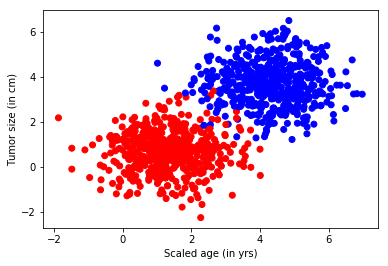

In [6]:
import numpy as np
np.random.seed(10)
num_classes = 2
mean = np.random.randn(num_classes)
cov = np.eye(num_classes)
X,Y = generate(1000,mean,cov,[3.0],True)

colors = ['r' if i == 0 else 'b' for i in Y[:]]
plt.scatter(X[:,0],X[:,1],c=colors)
plt.xlabel("Scaled age (in yrs)")
plt.ylabel("Tumor size (in cm)")
plt.show()

## 构建网络结构
使用一个神经元，先定义输入、输出两个占位符，然后是w和b的权重。

- 激活函数使用的是Sigmoid。
- 损失函数loss使用交叉熵，里面又加了一个平方差函数，用来评估模型的错误率。
- 优化器使用AdamOptimizer。

In [7]:
import tensorflow as tf
lab_dim = 1
input_dim = 2  
input_features = tf.placeholder(tf.float32,[None,input_dim])
input_labels = tf.placeholder(tf.float32,[None,lab_dim])
#定义学习率
W =tf.Variable(tf.random_normal([input_dim,lab_dim]),name='weights')
b = tf.Variable(tf.zeros([lab_dim]),name="bias")
output = tf.nn.sigmoid(tf.matmul(input_features,W)+b)
cross_entropy = -(input_labels*tf.log(output)+(1-input_labels)*tf.log(1-output))
ser=tf.square(input_labels-output)
loss = tf.reduce_mean(cross_entropy)
err = tf.reduce_mean(ser)
optimizer = tf.train.AdamOptimizer(0.04) #尽量用这个，因其收敛快，会动态调价梯度
train = optimizer.minimize(loss)

## 设置参数进行训练

Epoch: 0001 cost= 0.273162246 err= 0.14397092275321483
Epoch: 0002 cost= 0.177642629 err= 0.06699530617333949
Epoch: 0003 cost= 0.133184582 err= 0.04349664563778788
Epoch: 0004 cost= 0.107437395 err= 0.03250764231197536
Epoch: 0005 cost= 0.091054417 err= 0.026635829545557498
Epoch: 0006 cost= 0.079971023 err= 0.023100524756591766
Epoch: 0007 cost= 0.072089069 err= 0.020780712069245054
Epoch: 0008 cost= 0.066226751 err= 0.019159750192193313
Epoch: 0009 cost= 0.061681747 err= 0.017971555038820954
Epoch: 0010 cost= 0.058024656 err= 0.017067288808175363
Epoch: 0011 cost= 0.054988090 err= 0.016358208481688053
Epoch: 0012 cost= 0.052402031 err= 0.015788602086831815
Epoch: 0013 cost= 0.050155669 err= 0.015321933789527975
Epoch: 0014 cost= 0.048174411 err= 0.014933324810408521
Epoch: 0015 cost= 0.046405815 err= 0.014605254291382153
Epoch: 0016 cost= 0.044812012 err= 0.014325043420831208
Epoch: 0017 cost= 0.043364581 err= 0.014083295215095859
Epoch: 0018 cost= 0.042041559 err= 0.013872895923850

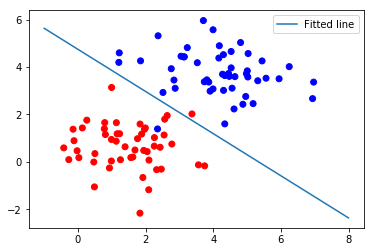

In [8]:
maxEpochs = 50
miniBatchSize = 25

# 启动session
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    # 向模型输入数据
    for epoch in range(maxEpochs):
        sumerr=0
        for i in range(np.int32(len(Y)/miniBatchSize)):
            x1 = X[i*miniBatchSize:(i+1)*miniBatchSize,:]
            y1 = np.reshape(Y[i*miniBatchSize:(i+1)*miniBatchSize],[-1,1])
            tf.reshape(y1,[-1,1])
            _,lossval,outputval,errval = sess.run([train,loss,output,err],feed_dict={input_features:x1,input_labels:y1})
            sumerr = sumerr+errval
        print ("Epoch:", '%04d' % (epoch+1), "cost=","{:.9f}".format(lossval),"err=",sumerr/np.int32(len(Y)/miniBatchSize))
        
    #数据可视化
    train_X,train_Y = generate(100,mean,cov,[3.0],True)
    colors = ['r' if i == 0 else 'b' for i in train_Y[:]]
    plt.scatter(train_X[:,0],train_X[:,1],c=colors)
    x =np.linspace(-1,8,200)
    y = -x*(sess.run(W)[0]/sess.run(W)[1])-sess.run(b)/sess.run(W)[1]
    plt.plot(x,y,label="Fitted line")
    plt.legend()
    plt.show()

## 线性可分概念
可以用直线分割的方式解决问题，则可以说这个问题是线性可分的。同理，类似这样的数据集就可以被称为线性可分数据集合。

# 用线性逻辑回归处理多分类问题
在实现过程中生成3类样本模拟数据，构造神经网络，通过softmax分类的分类的方法计算神经网络的输出值，并将其分开。
## 生成样本集
使用generate函数，生成2000个点、3类数据，并且使用one_hot编码。

In [15]:
np.random.seed(10)
cov = np.eye(num_classes)
imput_dim = 2
num_classes = 3
X,Y = generate(2000,mean,cov,[[3.0],[3.0,0]],False)
aa = [np.argmax(i) for i in Y]
colors = ['r' if i == 0 else 'b' if i == 1 else 'y' for i in aa[:]]
# 将具体的点依照不同的颜色显示出来
plt.scatter(X[:,0],X[:,1],c=colors)
plt.xlabel("Scaled age (in yrs)")
plt.ylabel("Tumor size (in cm)")
plt.show()

ValueError: mean must be 1 dimensional

TypeError: generate() missing 1 required positional argument: 'regression'